In [5]:
import glob
import os
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import time
from sklearn.svm import LinearSVC
import sklearn.svm as svm
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split
import sklearn.model_selection as grid_search
from scipy.ndimage.measurements import label
import pickle
from moviepy.editor import VideoFileClip

# import code for finding lanes
from lane_detection import *
from image_lane_finder import *
from video_lane_finder import *

ImportError: No module named 'lane_detection'

### Prepare Lane Finding

In [2]:
# First, set up everything from lane finding
# Load calibration images
calibration_image_names = glob.glob("camera_cal/calibration*.jpg")
calibration_images = [mpimg.imread(fname) for fname in calibration_image_names]
camera = Camera(calibration_images, (9, 6))

# calculate perspective transform matrix and its inverse using an image on which we know the lanes are straight
img = mpimg.imread("test_images/straight_lines1.jpg")
undistorted = camera.undistort(img)

src = np.float32([[194, img.shape[0]], [1112, img.shape[0]], [573, 463], [708, 463]])
dst = np.float32([[200, undistorted.shape[0]], [1000, undistorted.shape[0]], [200, 0], [1000, 0]])
perspective_M = cv2.getPerspectiveTransform(src, dst)
perspective_Minv = cv2.getPerspectiveTransform(dst, src)

# gradient and color thresholding processor
preprocessor = lambda x: thresholding_pipeline(x, s_thresh=(200, 255), r_thresh = (230,255), sx_thresh=(70, 100))

### Load Data

In [3]:
# Load test data
test_image_names = glob.glob("test_images/test*.jpg")
test_images = [mpimg.imread(fname) for fname in test_image_names]

In [4]:
# Load training image names
cars = []
for folder_name in [x for x in os.listdir("vehicles") if not (x == ".DS_Store")]:
    for image in glob.glob('vehicles/' + folder_name + '/*.png'):
        cars.append(image)

notcars = []
for folder_name in [x for x in os.listdir("non-vehicles") if not (x == ".DS_Store")]:
    for image in glob.glob('non-vehicles/' + folder_name + '/*.png'):
        notcars.append(image)

### Creating Features

In [5]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        # Use skimage.hog() to get both features and a visualization
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), cells_per_block=(cell_per_block, cell_per_block), visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    else:      
        #print("lala")
        # Use skimage.hog() to get features only
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), cells_per_block=(cell_per_block, cell_per_block), visualise=vis, feature_vector=feature_vec)
        return features

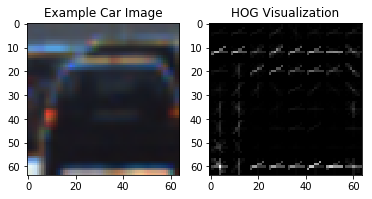

In [139]:
# Generate a random index to look at a car image
ind = np.random.randint(0, len(cars))
# Read in the image
image = mpimg.imread(cars[ind])
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
features, hog_image = get_hog_features(gray, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)


# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(image, cmap='gray')
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')
plt.show()

In [6]:
# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

In [7]:
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

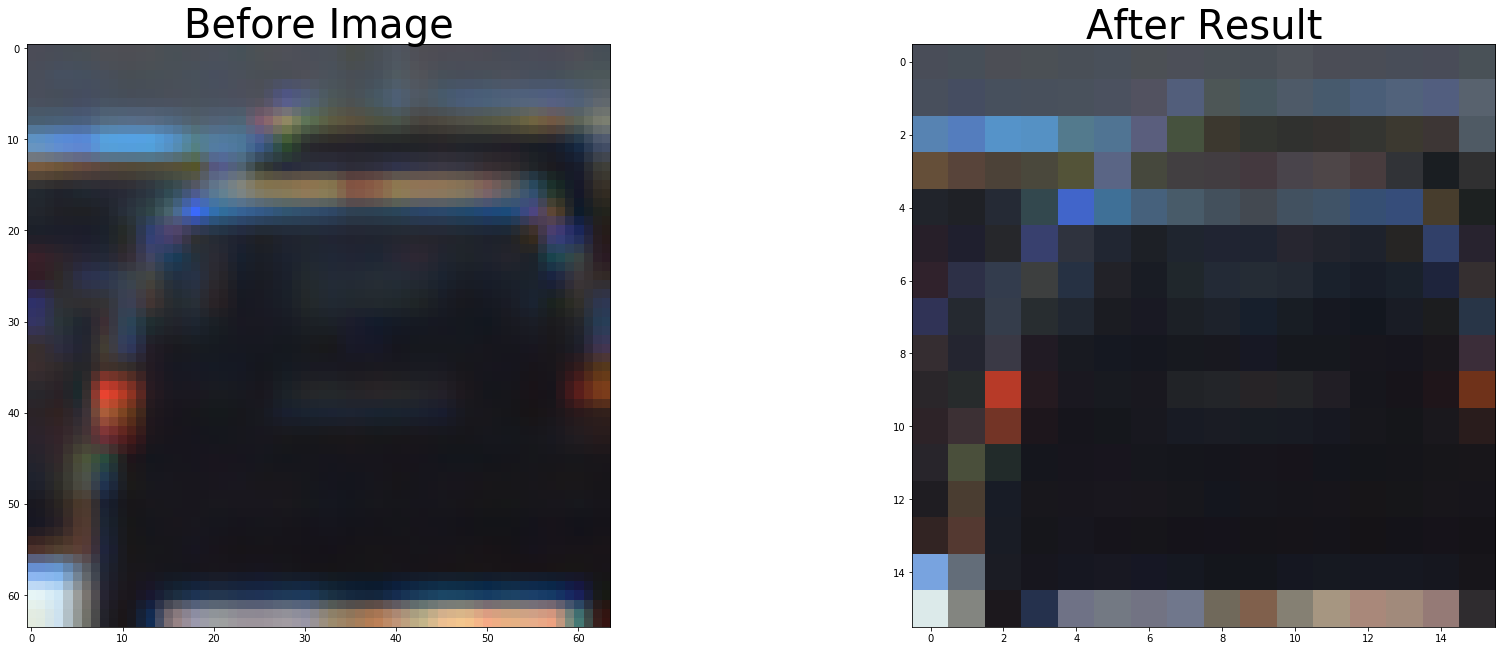

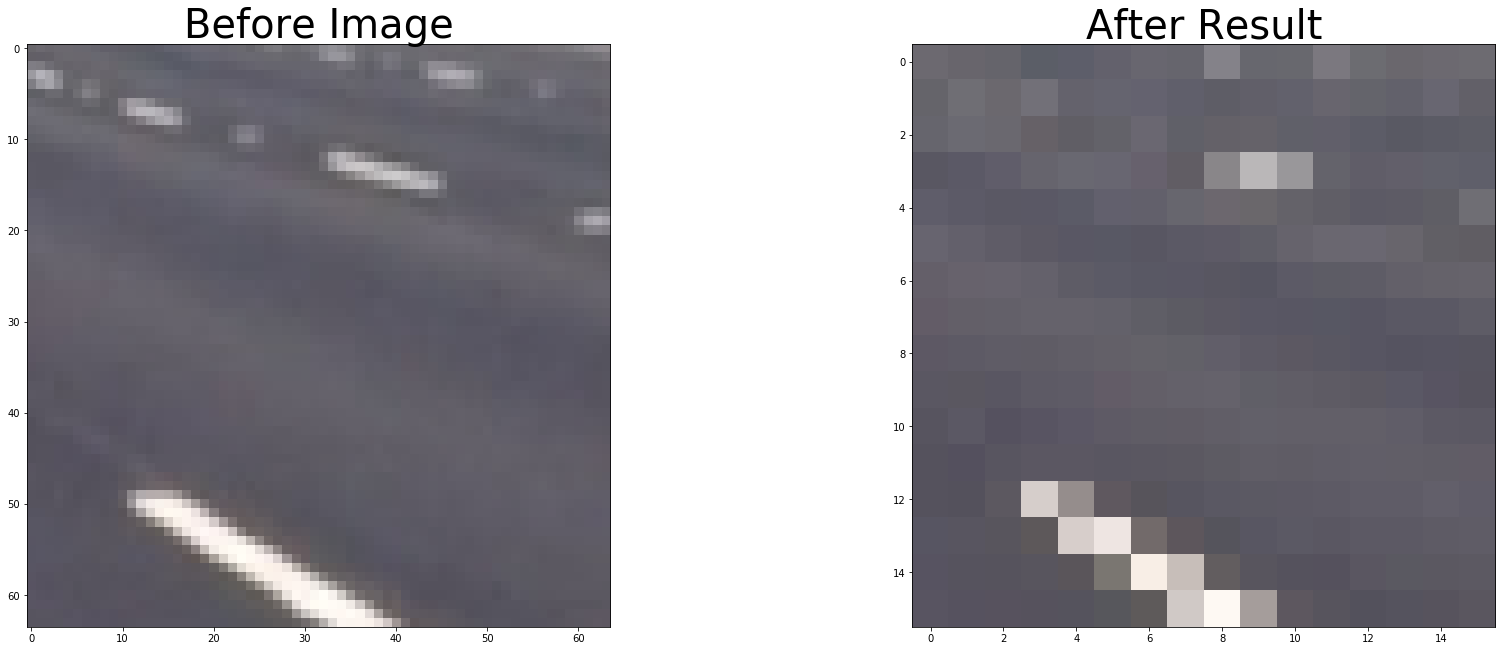

In [148]:
# Generate a random indeces
ind_car = np.random.randint(0, len(cars))
ind_non_car = np.random.randint(0, len(notcars))

# Read in the image
car_image = mpimg.imread(cars[ind])
non_car_image = mpimg.imread(notcars[ind_non_car])

out_car_image = cv2.resize(car_image, spatial_size)
out_non_car_image = cv2.resize(non_car_image, spatial_size)

plot_before_after(car_image, out_car_image)
plot_before_after(non_car_image, out_non_car_image)

In [137]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0, spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = cv2.imread(file)
        img_features = extract_features_single_image(image, cspace=cspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                        spatial_feat = spatial_feat, hist_feat = hist_feat, hog_feat = hog_feat)
        # Append the new feature vector to the features list
        features.append(np.concatenate(img_features))
    # Return list of feature vectors
    return features

In [136]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features_single_image(image, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    img_features = []
    # apply color conversion if other than 'RGB'
    if cspace != 'RGB':
        if cspace == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        elif cspace == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2LUV)
        elif cspace == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
        elif cspace == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
        elif cspace == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)
    else: feature_image = np.copy(image)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
    # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
    # Append the new feature vector to the features list
        img_features.append(hog_features)
    # Return list of feature vectors
    return img_features

### Visualize

In [10]:
# Define a function that takes an image, a list of bounding boxes, 
# and optional color tuple and line thickness as inputs
# then draws boxes in that color on the output
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    draw_img = np.copy(img)
    for bb in bboxes:
        cv2.rectangle(draw_img, bb[0], bb[1], color, thick)
    return draw_img

In [11]:
def plot_before_after(before, after, before_cmap = None, after_cmap = None):
    # Plot the result
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()

    ax1.imshow(before, before_cmap)
    ax1.set_title('Before Image', fontsize=40)

    ax2.imshow(after, after_cmap)
    ax2.set_title('After Result', fontsize=40)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    plt.show()

### Train SVM

In [12]:
# define parameters
colorspace = 'LUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 8
pix_per_cell = 8
cell_per_block = 2
hog_channel = 0 # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

In [138]:
t=time.time()
car_features = extract_features(cars, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

In [13]:
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

97.76 Seconds to extract HOG features...


In [14]:
# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

In [155]:
parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
svr = svm.SVC()
clf = grid_search.GridSearchCV(svr, parameters) 
clf.fit(X_train, y_train)
print(clf.best_params_)

{'C': 10, 'kernel': 'rbf'}


In [15]:
print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = svm.SVC(C=10, kernel='rbf')
#svc = LinearSVC(loss='hinge')
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the training accuracy of the SVN
print('Training Accuracy of SVC = ', round(svc.score(X_train, y_train), 4))
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

Using: 8 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 2432
89.73 Seconds to train SVC...
Training Accuracy of SVC =  1.0
Test Accuracy of SVC =  0.9944
My SVC predicts:  [ 1.  1.  0.  1.  1.  0.  1.  0.  1.  1.]
For these 10 labels:  [ 1.  1.  0.  1.  1.  0.  1.  0.  1.  1.]
0.06286 Seconds to predict 10 labels with SVC


In [17]:
# save the trained SVM
save_dict = {}
save_dict["svc"] = svc
save_dict["X_scaler"] = X_scaler
pickle.dump(save_dict, open( "svc_model.p", "wb" ))

In [15]:
# Load already trained SVM
load_dict = pickle.load(open("svc_model.p", "rb"))
svc = load_dict["svc"]
X_scaler = load_dict["X_scaler"]

### Detect Vechicles

In [164]:
def find_labeled_bboxes(labels):
    boxes = []
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        boxes.append(bbox)
    # Return the image
    return boxes

def find_cars(img, ystart, ystop, xstart, xstop, scale, step, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    boxes = []
    img_tosearch = img[int(ystart):int(ystop),xstart:xstop,:]
    ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_BGR2LUV)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    
    # we are extracting hog features only in one channel
    ch1 = ctrans_tosearch[:,:,0]
    
    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2

    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = step  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step

    # Compute L channel HOG features
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            
            # Extract HOG for this patch
            hog_features = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))

            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction

            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    

            test_prediction = svc.predict(test_features)

            if test_prediction == 1:
                xbox_left = np.int(xleft*scale) + int(xstart)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                boxes.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
    return boxes

In [27]:
def add_heat(heatmap, bbox_list):
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    return heatmap

def apply_threshold(heatmap, threshold):
    heatmap[heatmap <= threshold] = 0
    return heatmap

# box = (point1, point2) = ((x1, y1), (x2, y2))
# convert box to (centerx, centery, spanx, spany)
def box_to_centroid(box):
    spanx = (box[1][0] - box[0][0])/2.0
    spany = (box[1][1] - box[0][1])/2.0
    centerx = box[0][0] + spanx
    centery = box[0][1] + spany
    return (centerx, centery, spanx, spany)

def centroid_to_box(centroid):
    x1 = int(centroid[0] - centroid[2])
    x2 = int(centroid[0] + centroid[2])
    y1 = int(centroid[1] - centroid[3])
    y2 = int(centroid[1] + centroid[3])
    return ((x1, y1), (x2, y2))

def decay_tuples(a, b, factor):
    return tuple(map(lambda pair: decay(pair[0], pair[1], factor), zip(a, b)))

def decay(a, b, factor):
    return a * factor + (1.0 - factor) * b

def distance(p1, p2):
    return np.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1]) ** 2)

def combine_boxes(boxes_c, boxes_p):
    centroids_c = [box_to_centroid(box) for box in boxes_c]
    centroids_p = [box_to_centroid(box) for box in boxes_p]
    
    boxes = []
    for centroid_c in centroids_c:
        min_distance = 1000
        closest_centroid = None
        for centroid_p in centroids_p:
            dist = distance(centroid_c, centroid_p)
            if dist < min_distance:
                min_distance = dist
                closest_centroid = centroid_p
        if min_distance < 32 and closest_centroid != None:
            boxes.append(centroid_to_box(decay_tuples(closest_centroid, centroid_c, 0.8)))
        else:
            boxes.append(centroid_to_box(centroid_c))
    return boxes

In [184]:
def detect_vehicles_in_image(img, prev_heat = None, prev_boxes = None):
    heat = np.zeros_like(img[:,:,0]).astype(np.float)

    # run find_cars for different scales
    boxes_1 = find_cars(img, 400, 550, 200, 1100, 1.1, 2, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    boxes_2 = find_cars(img, 400, 650, 900, img.shape[1], 1.8, 2, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    boxes_4 = find_cars(img, 400, 700, 1000, img.shape[1], 2.3, 1, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    boxes_3 = find_cars(img, 410, 700, 900, img.shape[1], 1.9, 1, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    boxes_5 = find_cars(img, 400, 550, 200, 1100, 0.7, 4, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    boxes_6 = find_cars(img, 400, 650, 0, 380, 1.8, 2, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    boxes_7 = find_cars(img, 400, 700, 0, 280, 2.3, 1, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    boxes_8 = find_cars(img, 410, 700, 0, 380, 1.9, 1, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    
    boxes = boxes_1 + boxes_2 + boxes_3 + boxes_4 + boxes_5 + boxes_6 + boxes_7 + boxes_8

    heat = add_heat(heat, boxes)
    combined_heat = heat + prev_heat if prev_heat != None else heat
    heatmap = np.clip(apply_threshold(combined_heat, 2), 0, 255)
    labels = label(heatmap)

    label_boxes = find_labeled_bboxes(labels)
    combined_boxes = combine_boxes(label_boxes, prev_boxes) if prev_boxes != None else label_boxes
    
    return combined_heat, combined_boxes

def detect_vehicles_in_video(img):
    global n_frame, heat_prev, boxes_prev
    if n_frame%2 == 0:
        heat_prev, boxes_prev = detect_behicles_in_image(img, heat_prev, boxes_prev)
    n_frame+=1
    return boxes_prev

### Test On Images

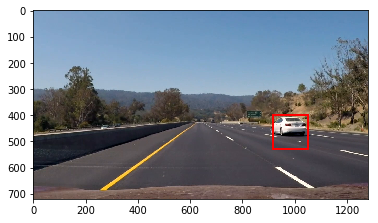

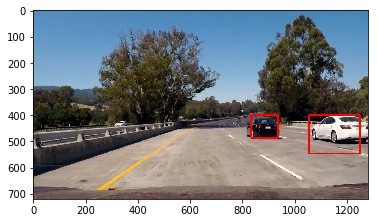

In [185]:
n_frame = 0
heat_prev = np.zeros((720, 1280))
boxes_prev = []
for image_name in glob.glob('clip_test*.png'):
    img = cv2.imread(image_name)
    plt.imshow(cv2.cvtColor(draw_boxes(img, detect_vehicles_in_image(img)[1]), cv2.COLOR_BGR2RGB))
    plt.show()

### Test On Video

In [119]:

video_lane_finder = VideoLaneFinder(camera, perspective_M, perspective_Minv, test_images[0].shape[:2], preprocessor)
def process_mpig_frame(img):
    # calculate the boxes
    car_boxes = find_vehicle_boxes_in_video(cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
    img_with_lanes = video_lane_finder.process_frame(img)
    return draw_boxes(img_with_lanes, car_boxes)

n_frame = 0
heat_prev = np.zeros((720, 1280))
boxes_prev = []
video = VideoFileClip("project_video.mp4")
out_video = video.fl_image(process_mpig_frame)
out_video.write_videofile("project_video_out.mp4", audio=False)

[MoviePy] >>>> Building video project_video_out_complete_4.mp4
[MoviePy] Writing video project_video_out_complete_4.mp4


100%|█████████▉| 1260/1261 [49:31<00:02,  2.77s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out_complete_4.mp4 



In [183]:
from IPython.display import HTML
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format("project_video_out.mp4"))